In [1]:
import detectevent
from detectevent import DetectEvent
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
%matplotlib ipympl
from scipy.integrate import simpson
from scipy.signal import savgol_filter

In [ ]:
df = pd.read_csv('usgs-data/01302020_shorter2.csv') # read in data
df = df.rename(columns={'00065': 'height', 'datetime': 'time'}) # rename columns

df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S%z") # convert time from strings to datetime

# smooth original data
# df['height'] = df['height'].rolling(10, center=True).mean()
# df['height'] = savgol_filter(df['height'], window_length=11, polyorder=2)

# method 1 compute the derivative dh/dt
df['time_num'] = df['time'].astype(np.int64)
df['dh_dt'] = np.gradient(df['height'], df['time_num'])

# smoothing dh/dt
df['dh_dt'] = savgol_filter(df['dh_dt'], window_length=11, polyorder=2)

# plot the hysteresis
plt.figure(figsize=(12, 6))
plt.plot(df['height'], df['dh_dt'])
# plt.plot(df['time'], df['height'])

In [ ]:
# Ensure time is datetime and calculate dh/dt
# df['time'] = pd.to_datetime(df['time'])
# df['dh_dt'] = np.gradient(df['height'])  # Assumes uniform time intervals

# Detect sign changes in derivative (peaks/troughs)
df['rising'] = df['dh_dt'] > 0
sign_changes = np.where(df['rising'].diff().fillna(False))[0]

# Group into events (rising + falling phases)
events = []
for i in range(0, len(sign_changes)-1, 2):
    start_idx = sign_changes[i]
    end_idx = sign_changes[i+1] if i+1 < len(sign_changes) else len(df)-1

    events.append({
        'start_time': df.iloc[start_idx]['time'],
        'end_time': df.iloc[end_idx]['time'],
        'peak_time': df.iloc[start_idx:end_idx+1]['height'].idxmax(),
        'max_height': df.iloc[start_idx:end_idx+1]['height'].max()
    })

events_df = pd.DataFrame(events)

In [ ]:
df = pd.read_csv('usgs-data/01302020_shorter2.csv')  # read in data
df = df.rename(columns={'00065': 'height', 'datetime': 'time'})  # rename columns
df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S%z")  # convert time from strings to datetime

# Method 1: compute the derivative dh/dt
df['time_num'] = df['time'].astype(np.int64)
df['dh_dt'] = np.gradient(df['height'], df['time_num'])

df['height'] = savgol_filter(df['height'], window_length=24, polyorder=2)

# Smoothing dh/dt
df['dh_dt'] = savgol_filter(df['dh_dt'], window_length=24, polyorder=2)
df['rising'] = df['dh_dt'] > 0

# Find all sign changes (both rising→falling and falling→rising)
sign_changes = np.where(df['rising'].diff().fillna(False) != 0)[0]

# Group into events (complete cycles)
events = []
# We need at least 2 sign changes to define an event
if len(sign_changes) >= 2:
    # Check if the first segment is rising or falling
    first_is_rising = df.iloc[sign_changes[0]]['rising']

    # Adjust the starting index if needed
    start_idx = 0
    if not first_is_rising:
        # If first segment is falling, it's the end of a previous event
        # Start with the next rising segment
        if len(sign_changes) > 1:
            start_idx = 1

    # Process complete events (rising + falling phases)
    for i in range(start_idx, len(sign_changes)-1, 2):
        if i+1 < len(sign_changes):
            # Start with a rising segment
            rising_start_idx = sign_changes[i]

            # The next sign change is where it starts falling
            falling_start_idx = sign_changes[i+1]

            # If there's another sign change, that's the end of falling
            falling_end_idx = sign_changes[i+2] if i+2 < len(sign_changes) else len(df)-1

            # Extract event data
            event_segment = df.iloc[rising_start_idx:falling_end_idx+1]

            # Find the peak (maximum height during the event)
            peak_idx = event_segment['height'].idxmax()
            peak_time = df.loc[peak_idx, 'time']
            max_height = df.loc[peak_idx, 'height']

            events.append({
                'start_time': df.iloc[rising_start_idx]['time'],
                'end_time': df.iloc[falling_end_idx]['time'],
                'peak_time': peak_time,
                'max_height': max_height,
                'rising_duration': df.iloc[falling_start_idx]['time'] - df.iloc[rising_start_idx]['time'],
                'falling_duration': df.iloc[falling_end_idx]['time'] - df.iloc[falling_start_idx]['time']
            })

events_df = pd.DataFrame(events)


In [205]:
min_duration = pd.Timedelta('90m')  # 1 hour minimum
events_df = events_df[events_df['end_time'] - events_df['start_time'] >= min_duration]

In [ ]:
len(events_df)

In [165]:
def merge_close_events(events_df, max_gap='1h'):
    if len(events_df) == 0:
        return events_df

    # Convert max_gap to Timedelta if it's a string
    max_gap = pd.Timedelta(max_gap)

    # Sort by start time
    events_df = events_df.sort_values('start_time').reset_index(drop=True)

    merged_events = []
    current_event = events_df.iloc[0].copy()  # Initialize with the first event

    for _, next_event in events_df.iloc[1:].iterrows():
        gap = next_event['start_time'] - current_event['end_time']

        # If gap <= max_gap, merge into current_event
        if gap <= max_gap:
            current_event['end_time'] = next_event['end_time']
            current_event['max_height'] = max(current_event['max_height'], next_event['max_height'])
            # Update peak_time to the time of the higher peak
            if next_event['max_height'] > current_event['max_height']:
                current_event['peak_time'] = next_event['peak_time']
        else:
            merged_events.append(current_event)
            current_event = next_event.copy()

    # Add the last event
    merged_events.append(current_event)

    return pd.DataFrame(merged_events)

# Example usage
events_df = merge_close_events(events_df, max_gap='5h')

In [184]:
def dynamic_merge(events_df, base_gap='1H', height_factor=0.1):
    events_df = events_df.sort_values('start_time')
    merged_events = []
    current_event = events_df.iloc[0].copy()

    for _, next_event in events_df.iloc[1:].iterrows():
        # Scale gap tolerance with event height (larger events = wider merge window)
        dynamic_gap = pd.Timedelta(base_gap) * (1 + height_factor * current_event['max_height'])
        gap = next_event['start_time'] - current_event['end_time']

        if gap <= dynamic_gap:
            current_event['end_time'] = next_event['end_time']
            current_event['max_height'] = max(current_event['max_height'], next_event['max_height'])
        else:
            merged_events.append(current_event)
            current_event = next_event.copy()

    merged_events.append(current_event)
    return pd.DataFrame(merged_events)

events_df = dynamic_merge(events_df, base_gap='5h')

In [ ]:
def calculate_loop_area(event_row):
    """Calculate hysteresis loop area for a single event."""
    # Extract event data
    mask = (df['time'] >= event_row['start_time']) & (df['time'] <= event_row['end_time'])
    event_data = df.loc[mask]

    # Split into rising/falling phases
    rising = event_data[event_data['dh_dt'] > 0]
    falling = event_data[event_data['dh_dt'] < 0]

    # Check minimum points requirement (at least 3 points for simpson)
    if len(rising) < 3 or len(falling) < 3:
        return 0.0  # Return 0 for invalid segments

    # Sort by height for proper integration
    rising = rising.sort_values('height')
    falling = falling.sort_values('height')

    try:
        # Calculate absolute loop area
        area = abs(
            simpson(rising['dh_dt'].values, rising['height'].values) -
            simpson(falling['dh_dt'].values, falling['height'].values)
        )
        return area
    except:
        return 0.0

# Apply with error handling
events_df['loop_area'] = events_df.apply(calculate_loop_area, axis=1)

# Filter events (keep top 50% by area)
min_area = events_df['loop_area'].quantile(0.000001)
events_df = events_df[events_df['loop_area'] > min_area].copy()

In [ ]:


plt.figure(figsize=(12, 6))

# Plot raw data
plt.plot(df['time'], df['height'], 'b-', label='Height', alpha=0.7)
# plt.plot(df['time'], df['height_smooth'], 'k-', label='Height', alpha=0.7)

# Highlight events
for _, event in events_df.iterrows():
    plt.axvspan(event['start_time'], event['end_time'],
               color='red', alpha=0.2, label='Event' if _ == 0 else "")
    # plt.scatter(event['peak_time'], event['max_height'],
    #            color='black', s=50, zorder=5)




# Rolling 95th percentile of dh/dt (adaptive to seasonal changes)
# df['rise_threshold'] = df['dh_dt'].rolling(7).quantile(0.95)
# flood_events = df[df['dh_dt'] > df['rise_threshold']]

# Dynamic threshold (top 5% of positive rates)
threshold = df['dh_dt'].quantile(0.90)
floods = df[(df['dh_dt'] > threshold) & (df['height'] > df['height'].quantile(0.35))]

# plt.plot(df['time'], df['height'], label='Height')
plt.scatter(floods['time'], floods['height'], color='red', label='Flood Events')
# plt.scatter(flood_events['time'], flood_events['height'], color='red', label='Flood Events')


plt.xlabel('Time')
plt.ylabel('Height')
plt.title('Height with Detected Events')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import ndimage
from datetime import timedelta

def detect_events_phase_space(data, height_col='gage_height', time_col='datetime',
                             smoothing_window=24, threshold=0.1, min_duration=6):
    """
    Detect hydrological events using phase space analysis (derivative vs height)

    Parameters:
    -----------
    data : pandas DataFrame
        DataFrame containing the gage height time series
    height_col : str
        Column name for gage height data
    time_col : str
        Column name for datetime data
    smoothing_window : int
        Window size for smoothing the data (in hours)
    threshold : float
        Threshold for derivative to be considered significant
    min_duration : int
        Minimum duration for an event in hours

    Returns:
    --------
    events : list of tuples
        List of (start_time, end_time) for each detected event
    """
    # Ensure data is sorted by time
    data = data.sort_values(by=time_col)

    # Convert to numeric if needed and handle missing values
    heights = pd.to_numeric(data[height_col], errors='coerce')
    heights = heights.interpolate()

    # Apply smoothing to reduce noise
    heights_smooth = ndimage.gaussian_filter1d(heights, sigma=smoothing_window/4)

    # Calculate derivative (rate of change)
    # Using simple difference with appropriate time scaling
    time_diff = np.diff(data[time_col].astype(np.int64)) / 1e9 / 3600  # Convert to hours
    height_diff = np.diff(heights_smooth)
    derivative = height_diff / time_diff

    # Add a 0 at the end to match length of original data
    derivative = np.append(derivative, 0)

    # Find where derivative exceeds threshold (both positive and negative)
    significant_changes = np.abs(derivative) > threshold

    # Find contiguous regions of significant changes
    labeled_regions, num_regions = ndimage.label(significant_changes)

    # Extract events
    events = []
    for i in range(1, num_regions + 1):
        event_indices = np.where(labeled_regions == i)[0]

        if len(event_indices) >= min_duration:  # Only keep events longer than min_duration
            start_idx = event_indices[0]
            end_idx = event_indices[-1]

            start_time = data[time_col].iloc[start_idx]
            end_time = data[time_col].iloc[end_idx]

            events.append((start_time, end_time))

    # For visualization purposes, create a phase plot
    plt.figure(figsize=(10, 6))
    plt.scatter(heights_smooth[:-1], derivative[:-1], alpha=0.5, s=3)

    # Highlight events
    for start, end in events:
        start_idx = data[data[time_col] == start].index[0]
        end_idx = data[data[time_col] == end].index[0]

        event_heights = heights_smooth[start_idx:end_idx+1]
        event_derivs = derivative[start_idx:end_idx+1]

        plt.plot(event_heights, event_derivs, 'r-', linewidth=2)

    plt.xlabel('Gage Height')
    plt.ylabel('Rate of Change (derivative)')
    plt.title('Phase Space Analysis for Event Detection')
    plt.grid(True)
    plt.savefig('phase_space_events.png')

    return events

detect_events_phase_space(df, 'height', 'time')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import ndimage
from datetime import timedelta
import matplotlib.dates as mdates

def detect_events_phase_space(data, height_col='gage_height', time_col='datetime',
                             smoothing_window=9, threshold=0.03, min_duration=5):
    """
    Detect hydrological events using phase space analysis (derivative vs height)
    and display them on a time series plot

    Parameters:
    -----------
    data : pandas DataFrame
        DataFrame containing the gage height time series
    height_col : str
        Column name for gage height data
    time_col : str
        Column name for datetime data
    smoothing_window : int
        Window size for smoothing the data (in hours)
    threshold : float
        Threshold for derivative to be considered significant
    min_duration : int
        Minimum duration for an event in hours

    Returns:
    --------
    events : list of tuples
        List of (start_time, end_time) for each detected event
    """
    # Ensure data is sorted by time
    data = data.sort_values(by=time_col)

    # Convert to numeric if needed and handle missing values
    heights = pd.to_numeric(data[height_col], errors='coerce')
    heights = heights.interpolate()

    # Apply smoothing to reduce noise
    heights_smooth = ndimage.gaussian_filter1d(heights, sigma=smoothing_window/4)

    # Calculate derivative (rate of change)
    # Using simple difference with appropriate time scaling
    time_diff = np.diff(data[time_col].astype(np.int64)) / 1e9 / 3600  # Convert to hours
    height_diff = np.diff(heights_smooth)
    derivative = height_diff / time_diff

    # Add a 0 at the end to match length of original data
    derivative = np.append(derivative, 0)

    # Find where derivative exceeds threshold (both positive and negative)
    significant_changes = np.abs(derivative) > threshold

    # Find contiguous regions of significant changes
    labeled_regions, num_regions = ndimage.label(significant_changes)

    # Extract events
    events = []
    for i in range(1, num_regions + 1):
        event_indices = np.where(labeled_regions == i)[0]

        if len(event_indices) >= min_duration:  # Only keep events longer than min_duration
            start_idx = event_indices[0]
            end_idx = event_indices[-1]

            start_time = data[time_col].iloc[start_idx]
            end_time = data[time_col].iloc[end_idx]

            events.append((start_time, end_time))

    # Create a time series plot with highlighted events
    plt.figure(figsize=(12, 6))

    # Plot height vs time
    plt.plot(data[time_col], heights_smooth, 'b-', linewidth=1.5, label='Smoothed Gage Height')
    plt.plot(data[time_col], heights, 'c-', alpha=0.5, linewidth=0.5, label='Raw Gage Height')

    # Highlight the events using axvspan
    colors = ['#ffcccc', '#ccffcc', '#ccccff', '#ffffcc', '#ffccff', '#ccffff']  # Different colors for events

    for idx, (start, end) in enumerate(events):
        # color = colors[idx % len(colors)]  # Cycle through colors for different events
        plt.axvspan(start, end, alpha=0.3, color='r',
                   label=f'Event {idx+1}' if idx < 10 else None)  # Only show first 10 in legend

        # Mark start and end points
        # start_height = heights_smooth[data[data[time_col] == start].index[0]]
        # end_height = heights_smooth[data[data[time_col] == end].index[0]]

        # plt.scatter(start, start_height, color='red', s=50, zorder=5)
        # plt.scatter(end, end_height, color='black', s=50, zorder=5)

    # Format the x-axis to show dates nicely
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels

    plt.xlabel('Time')
    plt.ylabel(f'{height_col} (units)')
    plt.title('Water Level Events Detection')
    plt.grid(True, alpha=0.3)

    # Add a legend but keep it manageable
    # if len(events) > 10:
    #     plt.legend(['Smoothed Gage Height', 'Raw Gage Height', 'Events (first 10 shown)'])
    # else:
    #     plt.legend()

    plt.tight_layout()
    plt.savefig('water_level_events.png')
    plt.show()

    return events

events = detect_events_phase_space(df, 'height', 'time')
print(len(events))

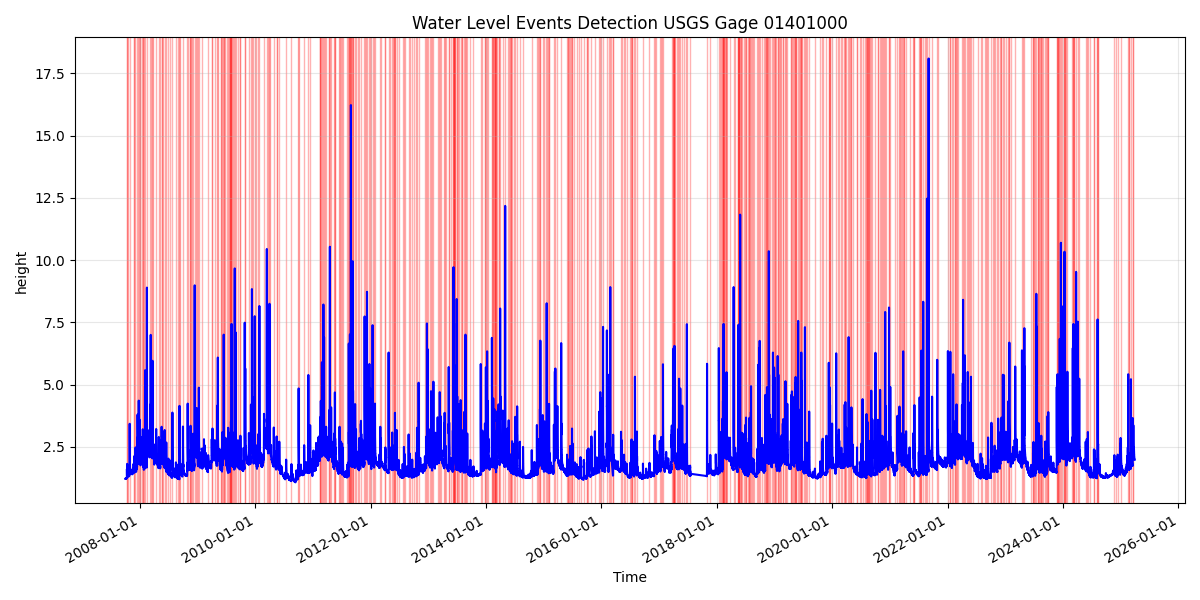

567


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import ndimage
from datetime import timedelta
import matplotlib.dates as mdates

def detect_events_phase_space(data, height_col='gage_height', time_col='datetime',
                             smoothing_window=24, threshold=0.1, min_duration=6,
                             merge_threshold=24):
    """
    Detect hydrological events using phase space analysis (derivative vs height)
    and display them on a time series plot

    Parameters:
    -----------
    data : pandas DataFrame
        DataFrame containing the gage height time series
    height_col : str
        Column name for gage height data
    time_col : str
        Column name for datetime data
    smoothing_window : int
        Window size for smoothing the data (in hours)
    threshold : float
        Threshold for derivative to be considered significant
    min_duration : int
        Minimum duration for an event in hours
    merge_threshold : int
        Time threshold (in hours) to merge nearby events

    Returns:
    --------
    events : list of tuples
        List of (start_time, end_time) for each detected event
    """
    # Ensure data is sorted by time
    data = data.sort_values(by=time_col)

    # Convert to numeric if needed and handle missing values
    heights = pd.to_numeric(data[height_col], errors='coerce')
    heights = heights.interpolate()

    # Apply smoothing to reduce noise
    heights_smooth = ndimage.gaussian_filter1d(heights, sigma=smoothing_window/4)

    # Calculate derivative (rate of change)
    # Using simple difference with appropriate time scaling
    time_diff = np.diff(data[time_col].astype(np.int64)) / 1e9 / 3600  # Convert to hours
    height_diff = np.diff(heights_smooth)
    derivative = height_diff / time_diff

    # Add a 0 at the end to match length of original data
    derivative = np.append(derivative, 0)

    # Find where derivative exceeds threshold (both positive and negative)
    significant_changes = np.abs(derivative) > threshold

    # Find contiguous regions of significant changes
    labeled_regions, num_regions = ndimage.label(significant_changes)

    # Extract events
    raw_events = []
    for i in range(1, num_regions + 1):
        event_indices = np.where(labeled_regions == i)[0]

        if len(event_indices) >= min_duration:  # Only keep events longer than min_duration
            start_idx = event_indices[0]
            end_idx = event_indices[-1]

            start_time = data[time_col].iloc[start_idx]
            end_time = data[time_col].iloc[end_idx]

            raw_events.append((start_time, end_time))

    # Merge events that are too close to each other
    if not raw_events:
        events = []
    else:
        # Sort events by start time
        raw_events.sort(key=lambda x: x[0])

        # Initialize merged events with the first event
        events = [raw_events[0]]

        # Merge subsequent events if they're close enough
        for current_start, current_end in raw_events[1:]:
            prev_start, prev_end = events[-1]

            # Calculate time difference between previous event end and current event start
            time_between = (current_start - prev_end).total_seconds() / 3600  # in hours

            if time_between <= merge_threshold:
                # Merge with previous event
                events[-1] = (prev_start, max(current_end, prev_end))
            else:
                # Add as a new event
                events.append((current_start, current_end))

    # Create a time series plot with highlighted events
    plt.figure(figsize=(12, 6))

    # Plot height vs time
    # plt.plot(data[time_col], heights_smooth, 'b-', linewidth=1.5, label='Smoothed Gage Height')
    # plt.plot(data[time_col], heights, 'c-', alpha=0.5, linewidth=0.5, label='Raw Gage Height')
    plt.plot(data[time_col], heights, 'b-', alpha=1, linewidth=1.5, label='Raw Gage Height')


    # Highlight the events using axvspan
    # colors = ['#ffcccc', '#ccffcc', '#ccccff', '#ffffcc', '#ffccff', '#ccffff']  # Different colors for events

    for idx, (start, end) in enumerate(events):
        # color = colors[idx % len(colors)]  # Cycle through colors for different events
        plt.axvspan(start, end, alpha=0.3, color='r',
                   label=f'Event {idx+1}' if idx < 10 else None)  # Only show first 10 in legend

        # Mark start and end points
        # start_height = heights_smooth[data[data[time_col] == start].index[0]]
        # end_height = heights_smooth[data[data[time_col] == end].index[0]]

        # plt.scatter(start, start_height, color='red', s=50, zorder=5)
        # plt.scatter(end, end_height, color='black', s=50, zorder=5)

    # Format the x-axis to show dates nicely
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels

    plt.xlabel('Time')
    plt.ylabel(f'{height_col}')
    plt.title('Water Level Events Detection USGS Gage 01401000')
    plt.grid(True, alpha=0.3)

    # Add a legend but keep it manageable
    # if len(events) > 10:
    #     plt.legend(['Smoothed Gage Height', 'Raw Gage Height', 'Events (first 10 shown)'])
    # else:
    #     plt.legend()

    plt.tight_layout()
    plt.savefig('water_level_events_merged.png', dpi=300)
    plt.show()

    return events


df = pd.read_csv('usgs-data/01401000.csv') # read in data
df = df.rename(columns={'00065': 'height', 'datetime': 'time'}) # rename columns

df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S%z") # convert time from strings to datetime

events = detect_events_phase_space(df, 'height', 'time', smoothing_window=12, threshold=0.10, min_duration=4, merge_threshold=30)
print(len(events))

mis-counted: 25
not counted: 1